**Dataset:** Indoor Scene Recognition

**Fontes:**

* http://web.mit.edu/torralba/www/indoor.html
* https://github.com/ashrutkumar/Indoor-scene-recognition

**Evaluation Set:** 
* https://web.mit.edu/torralba/www/TrainingImages.txt
* https://web.mit.edu/torralba/www/TestImages.txt

### Pacotes

In [1]:
# Attr2font
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets,transforms
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import os
import pandas as pd
import shutil
import random
random.seed(5)
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

# Indoor Scenes
import pandas as pd
import numpy as np
import os
import torch
import glob
import random
import copy
import matplotlib.pyplot as plt
from math import floor
%matplotlib inline

import torchvision
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, Sampler
from torchvision import transforms
from torch.utils.data import Dataset,SubsetRandomSampler,Sampler
from torch import nn
import torch.nn.functional as F
from torch import optim

from skimage import io, transform
from PIL import Image
import PIL.ImageEnhance as ie
import PIL.Image as im
from torch.autograd import Variable

### Google Drive

In [2]:
## Conexão com o google drive, se achar necessário
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [5]:
epochs=5
batch_size=64
size = 50
torch.manual_seed(17)

### indoorCVPR

In [5]:
# Baixando o Training Set
!wget http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar
!tar -xvf ./indoorCVPR_09.tar
# Evaluating Set
#!wget https://web.mit.edu/torralba/www/TrainingImages.txt
#!wget https://web.mit.edu/torralba/www/TestImages.txt

--2022-05-23 15:33:18--  http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar
Resolving groups.csail.mit.edu (groups.csail.mit.edu)... 128.30.2.44
Connecting to groups.csail.mit.edu (groups.csail.mit.edu)|128.30.2.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2592010240 (2.4G) [application/x-tar]
Saving to: ‘indoorCVPR_09.tar.1’

indoorCVPR_09.tar.1   1%[                    ]  25.26M  10.4MB/s               ^C
Images/
Images/airport_inside/
Images/airport_inside/airport_inside_0001.jpg
Images/airport_inside/airport_inside_0002.jpg
Images/airport_inside/airport_inside_0003.jpg
Images/airport_inside/airport_inside_0004.jpg
Images/airport_inside/airport_inside_0005.jpg
Images/airport_inside/airport_inside_0006.jpg
Images/airport_inside/airport_inside_0048.jpg
Images/airport_inside/airport_inside_0007.jpg
Images/airport_inside/airport_inside_0008.jpg
Images/airport_inside/airport_inside_0009.jpg
Images/airport_inside/airport_inside_0010.jpg
I

In [7]:
files=[x.split("/")[-1]for x in [x[0] for x in os.walk("Images")][1:]]
files.sort()
labeldict={}
count=0

for file in files:
    labeldict[file]=count
    count+=1
    
from collections import defaultdict
class_freq=defaultdict(int)
csvlist=[]

for file in files:
    images=os.listdir(os.path.join(os.getcwd() + "/Images",file))
    count=1
    for img in images:
        an=img.split(".")        
        newname=str(file)+"_"+str(count)+"."+str(an[-1])
        os.rename(os.path.join(os.getcwd() + "/Images",file,img),os.path.join(os.getcwd() + "/Images",newname))
        csvlist.append([file, labeldict[file],newname])
        class_freq[file]+=1
        count+=1
        
for file in files:
    os.rmdir(os.path.join(os.getcwd() + "/Images",file))

df = pd.DataFrame(csvlist,columns=["Category", "Category_Id","File"]) 
df.to_csv("Train.csv")

### Dataset

In [6]:
class ImageDataset(Dataset): 
    
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Id = File
        # Category = Category_Id
        img_name = os.path.join(self.root_dir, self.data_frame['File'][idx])         
        image = Image.open(img_name).convert('RGB')                               
        label = np.array(self.data_frame['Category_Id'][idx])                        
        if self.transform:            
            image = self.transform(image)                                         
        sample = (image, label) 
        return sample

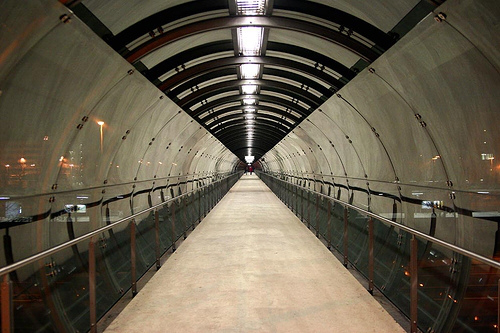

In [7]:
idx = 1
df = pd.read_csv("Train.csv")
img_name = os.path.join('./Images', df['File'][idx]) 
Image.open(img_name).convert('RGB')

#### Dataset e Dataloader

In [8]:
transform_augmented = transforms.Compose([
        transforms.RandomResizedCrop(50),
        #PowerPIL(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                     ])
transform_raw = transforms.Compose([
                     transforms.Resize(size=50),
                     transforms.ToTensor(),
                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) # https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2

transformation = transforms.Compose([
                     transforms.Resize(size=50),
                     transforms.ToTensor()])

In [9]:
def train_valid_split(dataset, test_size = 0.20, shuffle = False, random_seed = 0):
    length = dataset.__len__()
    indices = list(range(length))
    
    if shuffle == True:
        random.seed(random_seed)
        random.shuffle(indices)
    
    if type(test_size) is float:
        split = floor(test_size * length)
    elif type(test_size) is int:
        split = test_size
    else:
        raise ValueError('%s should be an int or a float' % str)
    return indices[split:], indices[:split]

In [10]:
class SubsetSampler(Sampler):
     
    def __init__(self, indices):
        self.num_samples = len(indices)
        self.indices = indices

    def __iter__(self):
        return iter(self.indices)
    
    def __len__(self):
        return self.num_samples

In [11]:
trainset = ImageDataset(csv_file = 'Train.csv', root_dir = './Images', transform=transform_augmented)
valset   = ImageDataset(csv_file = 'Train.csv', root_dir = './Images', transform=transform_augmented)

In [12]:
train_idx, valid_idx = train_valid_split(trainset, 0.20)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetSampler(valid_idx)

In [13]:
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
valid_loader = DataLoader(valset, batch_size=batch_size, sampler=valid_sampler, num_workers=2)

### Implementação VAE

In [14]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
       
        z = 32 # Dimensão do espaço latente
        
        #ENCODER
        self.fc1 = nn.Linear(50*50,1000) # Entra imagem 50x50, sai um vetor de 1000 elementos
        self.fc21 = nn.Linear(1000,z)   # Mean - Entra vetor de 1000 elementos, sai um vetor de 32
        self.fc22 = nn.Linear(1000,z)   # Variance - Entra vetor de 1000 elementos sai um vetor de 32
        
        #DECODER
        self.fc3 = nn.Linear(z,1000)
        self.fc4 = nn.Linear(1000,50*50)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        
        # don't forget forward pass re-index
        
        mu, logvar = self.encode(x.view(-1, 50*50))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### Implementação Loss Function

In [15]:
def loss_function(recon_x, x, mu, logvar):
    
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 50*50), reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

### Criação do Modelo

In [16]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=VAE().to(device)
print('Device: ',device)
model=VAE().to(device)
optimizer=optim.Adam(model.parameters(),lr=1e-3)

Device:  cuda


### Loops de Treinamento e Avaliação

In [17]:
def evaluate(evaluate_data):
    
    
    val_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(evaluate_data):
            
            data=data.to(device)
            recon_batch,mu,logvar=model(data)
            val_loss += loss_function(recon_batch,data,mu,logvar).item()
            
            
            if i == 0:
                n = min(data.size(0), 16)
                comparison = torch.cat([data[:n],
                                        recon_batch.view(batch_size, 3, 50, 50)[:n]]) # 3 = numero de canais
                save_image(comparison.cpu(),
                           '../content/results/reconstruction_' + str(epoch) + '.pdf', nrow=n)

    val_loss /= len(evaluate_data.dataset)
    return val_loss


def sample_latent_space(epoch):
    with torch.no_grad():
        
        # how to sample from our latent space
        sample=torch.randn(64,32).to(device)
        sample=model.decode(sample).cpu()
        
        save_image(sample.view(64, 1, 50, 50),
                   '../content/results/sample_' + str(epoch) + '.pdf')

In [18]:
def train(epoch, train_loader, val_loader):

    model.train()
    train_loss = 0
    
    progress_bar = tqdm(train_loader, desc='Epoch {:03d}'.format(epoch), leave=False, disable=False)
    for data, _ in progress_bar:
        
        data=data.to(device)
        optimizer.zero_grad()
        recon_batch,mu,logvar=model(data)

        loss=loss_function(recon_batch,data,mu,logvar)
        loss.backward()
        train_loss+=loss.item()
        optimizer.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(data))})

    average_train_loss = train_loss / len(train_loader.dataset)
    tqdm.write('Training set loss (average, epoch {:03d}): {:.3f}'.format(epoch, average_train_loss))
    val_loss = evaluate(val_loader)
    tqdm.write('\t\t\t\t====> Validation set loss: {:.3f}'.format(val_loss))

    train_losses.append(average_train_loss)
    val_losses.append(val_loss)
    
    if epoch%300==0:
        torch.save(model.state_dict(), f'../content/models/epoch_{epoch}.model')

### Treinamento

In [ ]:
epochs = 500

train_losses,val_losses=[],[]

for epoch in range(1,epochs+1):
  train(epoch, train_loader, valid_loader)
  sample_latent_space(epoch)

np.savetxt('../content/models/training_losses.txt', np.array(train_losses), delimiter='\n')
np.savetxt('../content/models/validation_losses.txt', np.array(val_losses), delimiter='\n')


Epoch 001:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 001): 1279192.877
				====> Validation set loss: -43280.677


Epoch 002:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 002): -171516.844
				====> Validation set loss: -41247.149


Epoch 003:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 003): -181400.928
				====> Validation set loss: -40992.732


Epoch 004:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 004): -187293.179
				====> Validation set loss: -47309.770


Epoch 005:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 005): -191371.609
				====> Validation set loss: -50760.646


Epoch 006:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 006): -195221.088
				====> Validation set loss: -46334.310


Epoch 007:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 007): -198149.508
				====> Validation set loss: -46206.573


Epoch 008:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 008): -201218.978
				====> Validation set loss: -45684.996


Epoch 009:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 009): -205190.912
				====> Validation set loss: -51017.980


Epoch 010:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 010): -205493.101
				====> Validation set loss: -51833.583


Epoch 011:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 011): -208665.766
				====> Validation set loss: -55190.494


Epoch 012:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 012): -209191.326
				====> Validation set loss: -52986.379


Epoch 013:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 013): 8389075393327479808.000
				====> Validation set loss: 155065990420953550188284215296.000


Epoch 014:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 014): 2972004707846364672.000
				====> Validation set loss: -55926.095


Epoch 015:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 015): -208409.017
				====> Validation set loss: -56572.211


Epoch 016:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 016): 13683556.062
				====> Validation set loss: 311770237471.382


Epoch 017:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 017): 2823603950761.032
				====> Validation set loss: -36050.224


Epoch 018:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 018): 6432130.405
				====> Validation set loss: -43628.789


Epoch 019:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 019): -214510.469
				====> Validation set loss: -52300.102


Epoch 020:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 020): -215105.108
				====> Validation set loss: -47214.516


Epoch 021:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 021): 687362.334
				====> Validation set loss: -53998.527


Epoch 022:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 022): -214073.335
				====> Validation set loss: -50710.764


Epoch 023:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 023): -214096.370
				====> Validation set loss: -52064.143


Epoch 024:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 024): -213033.393
				====> Validation set loss: -59112.468


Epoch 025:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 025): -212174.294
				====> Validation set loss: -47035.901


Epoch 026:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 026): -214530.062
				====> Validation set loss: -54062.703


Epoch 027:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 027): -214342.605
				====> Validation set loss: -50029.669


Epoch 028:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 028): -212522.246
				====> Validation set loss: -47248.114


Epoch 029:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 029): -203995.171
				====> Validation set loss: -57031.368


Epoch 030:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 030): -140769.760
				====> Validation set loss: -57572.008


Epoch 031:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 031): -205805.400
				====> Validation set loss: -53549.592


Epoch 032:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 032): -216149.063
				====> Validation set loss: -54055.581


Epoch 033:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 033): -213649.873
				====> Validation set loss: -55233.353


Epoch 034:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 034): -167121.326
				====> Validation set loss: -57779.580


Epoch 035:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 035): -215406.476
				====> Validation set loss: -56614.352


Epoch 036:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 036): -214889.558
				====> Validation set loss: -48704.590


Epoch 037:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 037): -215779.238
				====> Validation set loss: -55827.473


Epoch 038:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 038): -215188.747
				====> Validation set loss: -55273.381


Epoch 039:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 039): -216578.324
				====> Validation set loss: -51495.806


Epoch 040:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 040): -219433.506
				====> Validation set loss: -51720.292


Epoch 041:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 041): -178472.288
				====> Validation set loss: -50673.523


Epoch 042:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 042): -215273.882
				====> Validation set loss: -54312.411


Epoch 043:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 043): -219886.794
				====> Validation set loss: -48679.273


Epoch 044:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 044): -219281.173
				====> Validation set loss: -57494.841


Epoch 045:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 045): -219250.712
				====> Validation set loss: -52828.594


Epoch 046:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 046): -214246.750
				====> Validation set loss: -52654.955


Epoch 047:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 047): -218553.071
				====> Validation set loss: -53568.995


Epoch 048:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 048): -220423.389
				====> Validation set loss: -53464.811


Epoch 049:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 049): -221637.692
				====> Validation set loss: -58349.785


Epoch 050:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 050): 221526.045
				====> Validation set loss: -58019.064


Epoch 051:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 051): -221362.091
				====> Validation set loss: 19405.334


Epoch 052:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 052): -222136.589
				====> Validation set loss: -53371.351


Epoch 053:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 053): -221276.892
				====> Validation set loss: 86533746.431


Epoch 054:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 054): -220247.304
				====> Validation set loss: -56065.998


Epoch 055:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 055): -207660.051
				====> Validation set loss: -52861.984


Epoch 056:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 056): -223262.583
				====> Validation set loss: -60577.456


Epoch 057:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 057): -223996.691
				====> Validation set loss: -59346.799


Epoch 058:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 058): -164541.435
				====> Validation set loss: -56739.438


Epoch 059:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 059): -222604.064
				====> Validation set loss: -58550.379


Epoch 060:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 060): -225167.888
				====> Validation set loss: -60697.789


Epoch 061:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 061): -226062.817
				====> Validation set loss: -59644.794


Epoch 062:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 062): -205127.530
				====> Validation set loss: -54473.248


Epoch 063:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 063): -226884.000
				====> Validation set loss: -53392.230


Epoch 064:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 064): -227408.075
				====> Validation set loss: -58243.198


Epoch 065:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 065): -228575.139
				====> Validation set loss: -58664.325


Epoch 066:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 066): -227586.335
				====> Validation set loss: -61288.012


Epoch 067:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 067): 14079554.379
				====> Validation set loss: -60523.160


Epoch 068:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 068): -229203.598
				====> Validation set loss: 909145.599


Epoch 069:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 069): 68132998.389
				====> Validation set loss: -48687.129


Epoch 070:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 070): 172219517893.755
				====> Validation set loss: 3297325162110997.000


Epoch 071:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 071): 209621765492390.125
				====> Validation set loss: 134543484351964162031616.000


Epoch 072:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 072): 92115496258.786
				====> Validation set loss: -53664.069


Epoch 073:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 073): 7710390803119969165062963200.000
				====> Validation set loss: -52406.936


Epoch 074:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 074): 121438949248178241536.000
				====> Validation set loss: -58324.858


Epoch 075:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 075): 156650849.704
				====> Validation set loss: 2431405788734897152.000


Epoch 076:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 076): 14912913035.842
				====> Validation set loss: -58159.505


Epoch 077:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 077): 253205161937984.688
				====> Validation set loss: -56598.260


Epoch 078:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 078): 2089956.043
				====> Validation set loss: -54061.487


Epoch 079:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 079): -230383.085
				====> Validation set loss: 1464807.569


Epoch 080:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 080): -228234.682
				====> Validation set loss: -50034.220


Epoch 081:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 081): 32526066780959819169792.000
				====> Validation set loss: -53083.237


Epoch 082:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 082): 6267019.155
				====> Validation set loss: -57374.050


Epoch 083:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 083): -227682.545
				====> Validation set loss: -56985.542


Epoch 084:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 084): 99235354557090224.000
				====> Validation set loss: -60318.433


Epoch 085:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 085): 4121543.197
				====> Validation set loss: -57438.668


Epoch 086:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 086): 27391976950570.570
				====> Validation set loss: -58737.535


Epoch 087:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 087): 2306307.827
				====> Validation set loss: -57509.311


Epoch 088:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 088): 73178363576.590
				====> Validation set loss: -54654.899


Epoch 089:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 089): -227325.065
				====> Validation set loss: -57885.821


Epoch 090:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 090): -221331.699
				====> Validation set loss: -59755.732


Epoch 091:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 091): -228144.772
				====> Validation set loss: -57632.844


Epoch 092:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 092): 707958995000209.375
				====> Validation set loss: -52608.095


Epoch 093:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 093): -232918.375
				====> Validation set loss: 3382111.452


Epoch 094:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 094): 1323160833053.789
				====> Validation set loss: -57700.681


Epoch 095:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 095): 5042423273.988
				====> Validation set loss: -59860.353


Epoch 096:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 096): 1181765164974.967
				====> Validation set loss: -57498.431


Epoch 097:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 097): -232513.739
				====> Validation set loss: -58152.798


Epoch 098:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 098): -233618.361
				====> Validation set loss: -57526.232


Epoch 099:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 099): -233945.526
				====> Validation set loss: -57332.442


Epoch 100:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 100): -205441.142
				====> Validation set loss: 235154232775912736.000


Epoch 101:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 101): 6654588.135
				====> Validation set loss: -56930.878


Epoch 102:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 102): 31748.946
				====> Validation set loss: -57917.382


Epoch 103:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 103): -229537.397
				====> Validation set loss: 136641792.404


Epoch 104:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 104): -235014.005
				====> Validation set loss: -62206.742


Epoch 105:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 105): -235063.456
				====> Validation set loss: -58076.673


Epoch 106:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 106): -106100.344
				====> Validation set loss: -60139.911


Epoch 107:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 107): 2196928.901
				====> Validation set loss: -59878.110


Epoch 108:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 108): 2619588322.747
				====> Validation set loss: -58385.750


Epoch 109:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 109): 127561230.632
				====> Validation set loss: -60265.877


Epoch 110:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 110): 110199.489
				====> Validation set loss: 16479563.652


Epoch 111:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 111): -39041.928
				====> Validation set loss: -58285.995


Epoch 112:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 112): 173597.406
				====> Validation set loss: -11078.832


Epoch 113:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 113): -234080.963
				====> Validation set loss: 163999744103631224832.000


Epoch 114:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 114): 116956368.796
				====> Validation set loss: -58854.256


Epoch 115:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 115): -236197.553
				====> Validation set loss: -54808.201


Epoch 116:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 116): -235778.266
				====> Validation set loss: -58635.574


Epoch 117:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 117): 91715897.678
				====> Validation set loss: -51516.020


Epoch 118:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 118): 17213606233.951
				====> Validation set loss: 1740.058


Epoch 119:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 119): 7478623236088.396
				====> Validation set loss: -57191.569


Epoch 120:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 120): -235452.596
				====> Validation set loss: -57962.088


Epoch 121:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 121): -231291.745
				====> Validation set loss: -59997.716


Epoch 122:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 122): -122127.026
				====> Validation set loss: -56045.797


Epoch 123:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 123): 1404985.401
				====> Validation set loss: -57534.700


Epoch 124:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 124): 260183.849
				====> Validation set loss: 536066700.053


Epoch 125:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 125): 1312627.431
				====> Validation set loss: 8006025.421


Epoch 126:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 126): 7673210863171.472
				====> Validation set loss: -58726.398


Epoch 127:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 127): 105966.173
				====> Validation set loss: -54275.899


Epoch 128:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 128): -236990.903
				====> Validation set loss: -59618.046


Epoch 129:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 129): -238058.578
				====> Validation set loss: -59044.609


Epoch 130:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 130): -228529.932
				====> Validation set loss: -60994.182


Epoch 131:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 131): 850829.208
				====> Validation set loss: -56153.273


Epoch 132:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 132): -239446.709
				====> Validation set loss: -42770.715


Epoch 133:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 133): 31785466.864
				====> Validation set loss: -59621.966


Epoch 134:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 134): 1279589.350
				====> Validation set loss: -58614.318


Epoch 135:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 135): 178924278943.287
				====> Validation set loss: -59871.640


Epoch 136:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 136): 525103.943
				====> Validation set loss: 1706687137914.302


Epoch 137:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 137): -235411.251
				====> Validation set loss: -61389.935


Epoch 138:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 138): 280138.625
				====> Validation set loss: -56933.729


Epoch 139:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 139): -239675.664
				====> Validation set loss: -58039.381


Epoch 140:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 140): 93260.651
				====> Validation set loss: -57805.618


Epoch 141:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 141): -235695.649
				====> Validation set loss: -59184.095


Epoch 142:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 142): 13286999913789.004
				====> Validation set loss: -57572.546


Epoch 143:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 143): -201060.022
				====> Validation set loss: -58540.202


Epoch 144:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 144): -188683.388
				====> Validation set loss: -61570.047


Epoch 145:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 145): -238197.889
				====> Validation set loss: -57828.259


Epoch 146:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 146): 26085547052582244.000
				====> Validation set loss: -60718.248


Epoch 147:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 147): -237173.245
				====> Validation set loss: -60248.557


Epoch 148:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 148): -224713.970
				====> Validation set loss: -62324.564


Epoch 149:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 149): -240790.782
				====> Validation set loss: -54448.863


Epoch 150:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 150): -240200.627
				====> Validation set loss: -59960.919


Epoch 151:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 151): -240236.555
				====> Validation set loss: -52830.135


Epoch 152:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 152): 1320997423.752
				====> Validation set loss: -62166.030


Epoch 153:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 153): -235366.178
				====> Validation set loss: -60715.087


Epoch 154:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 154): -242351.168
				====> Validation set loss: 787105.014


Epoch 155:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 155): 21168064.439
				====> Validation set loss: -58987.539


Epoch 156:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 156): 7115271188.696
				====> Validation set loss: -59083.728


Epoch 157:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 157): -241645.384
				====> Validation set loss: -57750.460


Epoch 158:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 158): -240762.598
				====> Validation set loss: -52127.879


Epoch 159:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 159): 150367189025.967
				====> Validation set loss: 10972521.388


Epoch 160:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 160): -238577.528
				====> Validation set loss: -52563.415


Epoch 161:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 161): 26377046.973
				====> Validation set loss: 21336714993.217


Epoch 162:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 162): -74378.446
				====> Validation set loss: -57151.686


Epoch 163:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 163): -239730.374
				====> Validation set loss: -56982.845


Epoch 164:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 164): 1768929398.753
				====> Validation set loss: -25608.626


Epoch 165:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 165): -213571.865
				====> Validation set loss: -59628.827


Epoch 166:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 166): -240105.055
				====> Validation set loss: -58834.076


Epoch 167:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 167): -239414.708
				====> Validation set loss: -61263.948


Epoch 168:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 168): -240047.847
				====> Validation set loss: -54280.624


Epoch 169:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 169): -239791.110
				====> Validation set loss: -60380.494


Epoch 170:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 170): -240811.372
				====> Validation set loss: -58855.082


Epoch 171:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 171): 282939.676
				====> Validation set loss: -60912.168


Epoch 172:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 172): -241736.368
				====> Validation set loss: -59616.526


Epoch 173:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 173): 2711924055161.849
				====> Validation set loss: -61353.003


Epoch 174:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 174): -209689.882
				====> Validation set loss: -59673.211


Epoch 175:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 175): 495313550.423
				====> Validation set loss: -57697.435


Epoch 176:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 176): -241794.730
				====> Validation set loss: 16173994.993


Epoch 177:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 177): -202463.376
				====> Validation set loss: -62185.395


Epoch 178:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 178): -241795.997
				====> Validation set loss: -59821.373


Epoch 179:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 179): -244445.167
				====> Validation set loss: -62533.836


Epoch 180:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 180): 59606776746181.195
				====> Validation set loss: 29086993.018


Epoch 181:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 181): 33210816.531
				====> Validation set loss: -58348.673


Epoch 182:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 182): -241758.185
				====> Validation set loss: -62407.642


Epoch 183:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 183): 363655.275
				====> Validation set loss: 231416.447


Epoch 184:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 184): 612625.634
				====> Validation set loss: -60021.579


Epoch 185:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 185): 209429131820045696.000
				====> Validation set loss: -59459.381


Epoch 186:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 186): -241523.993
				====> Validation set loss: -60299.276


Epoch 187:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 187): 19572409.970
				====> Validation set loss: -60501.628


Epoch 188:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 188): -242138.564
				====> Validation set loss: -59325.490


Epoch 189:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 189): 10173969982663.670
				====> Validation set loss: -61881.608


Epoch 190:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 190): -243240.492
				====> Validation set loss: -59788.918


Epoch 191:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 191): -242026.769
				====> Validation set loss: -56247.477


Epoch 192:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 192): -233438.515
				====> Validation set loss: -62132.080


Epoch 193:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 193): -239649.255
				====> Validation set loss: -60690.075


Epoch 194:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 194): 3644457290664976.000
				====> Validation set loss: -33466.961


Epoch 195:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 195): 23210961.010
				====> Validation set loss: -61392.898


Epoch 196:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 196): -242907.862
				====> Validation set loss: -60022.592


Epoch 197:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 197): -244076.444
				====> Validation set loss: -56450.182


Epoch 198:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 198): 1380694568104.504
				====> Validation set loss: -62587.102


Epoch 199:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 199): -242609.366
				====> Validation set loss: -59932.050


Epoch 200:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 200): -243390.428
				====> Validation set loss: -59444.189


Epoch 201:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 201): -242454.686
				====> Validation set loss: 2020154763.618


Epoch 202:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 202): -240889.186
				====> Validation set loss: -61425.017


Epoch 203:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 203): -230474.675
				====> Validation set loss: -60649.435


Epoch 204:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 204): 14124921036780631677206528.000
				====> Validation set loss: -62190.772


Epoch 205:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 205): 257526425.465
				====> Validation set loss: -61534.182


Epoch 206:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 206): 99939193.970
				====> Validation set loss: 6920990.226


Epoch 207:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 207): -241163.503
				====> Validation set loss: -61320.274


Epoch 208:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 208): -245650.676
				====> Validation set loss: -61685.070


Epoch 209:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 209): -242474.524
				====> Validation set loss: -60372.099


Epoch 210:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 210): -243840.768
				====> Validation set loss: 83430754.494


Epoch 211:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 211): 2463943387277427124207616.000
				====> Validation set loss: -58980.609


Epoch 212:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 212): -181295.472
				====> Validation set loss: -59027.226


Epoch 213:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 213): -240033.924
				====> Validation set loss: -60165.553


Epoch 214:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 214): -231105.302
				====> Validation set loss: -60517.394


Epoch 215:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 215): 109432.051
				====> Validation set loss: -61324.747


Epoch 216:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 216): 159893.759
				====> Validation set loss: -59839.539


Epoch 217:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 217): -161476.758
				====> Validation set loss: -64336.372


Epoch 218:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 218): -244247.647
				====> Validation set loss: -62567.844


Epoch 219:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 219): 1298054397238.752
				====> Validation set loss: -59555.548


Epoch 220:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 220): -226650.660
				====> Validation set loss: -60262.767


Epoch 221:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 221): -243453.055
				====> Validation set loss: 2709364780.313


Epoch 222:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 222): -243906.273
				====> Validation set loss: -63505.920


Epoch 223:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 223): 460618830.201
				====> Validation set loss: -57967.038


Epoch 224:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 224): 5636546.337
				====> Validation set loss: -60966.089


Epoch 225:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 225): 8135110.587
				====> Validation set loss: -59986.786


Epoch 226:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 226): -240921.084
				====> Validation set loss: -48672.974


Epoch 227:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 227): 575141904784.290
				====> Validation set loss: 293591.237


Epoch 228:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 228): -210336.171
				====> Validation set loss: -61488.967


Epoch 229:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 229): -235743.073
				====> Validation set loss: -60683.251


Epoch 230:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 230): -191661.752
				====> Validation set loss: -61815.847


Epoch 231:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 231): -241900.832
				====> Validation set loss: 1267260291.047


Epoch 232:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 232): -241640.577
				====> Validation set loss: -58185.838


Epoch 233:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 233): -182149.483
				====> Validation set loss: -61145.413


Epoch 234:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 234): 2456966.774
				====> Validation set loss: -57704.265


Epoch 235:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 235): 15195066.276
				====> Validation set loss: -59039.377


Epoch 236:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 236): 8016676498746.810
				====> Validation set loss: -62619.227


Epoch 237:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 237): -196453.299
				====> Validation set loss: -50405.240


Epoch 238:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 238): 96788.703
				====> Validation set loss: 178634.551


Epoch 239:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 239): -239546.301
				====> Validation set loss: -63237.883


Epoch 240:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 240): -244671.045
				====> Validation set loss: -61514.691


Epoch 241:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 241): 1674552926.664
				====> Validation set loss: -61275.953


Epoch 242:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 242): -146803.140
				====> Validation set loss: -56071.648


Epoch 243:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 243): -243057.166
				====> Validation set loss: -57494.844


Epoch 244:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 244): 220104994.302
				====> Validation set loss: -62940.265


Epoch 245:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 245): -242884.524
				====> Validation set loss: -61639.913


Epoch 246:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 246): 180426822.606
				====> Validation set loss: -61062.094


Epoch 247:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 247): -240395.579
				====> Validation set loss: -60220.332


Epoch 248:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 248): -185131.492
				====> Validation set loss: -59272.911


Epoch 249:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 249): 1308252.796
				====> Validation set loss: 896672.536


Epoch 250:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 250): -242121.302
				====> Validation set loss: -63040.514


Epoch 251:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 251): -242997.672
				====> Validation set loss: 6894037.079


Epoch 252:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 252): 1117567222.961
				====> Validation set loss: -61109.368


Epoch 253:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 253): -204599.651
				====> Validation set loss: 888203.029


Epoch 254:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 254): -161841.844
				====> Validation set loss: -60508.749


Epoch 255:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 255): -239656.513
				====> Validation set loss: -49672.265


Epoch 256:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 256): 82963867690.889
				====> Validation set loss: -62242.122


Epoch 257:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 257): -228607.563
				====> Validation set loss: -60349.032


Epoch 258:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 258): 389130.101
				====> Validation set loss: 266385543932.880


Epoch 259:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 259): 124408036.113
				====> Validation set loss: -62803.734


Epoch 260:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 260): -242818.405
				====> Validation set loss: -61158.843


Epoch 261:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 261): -242613.800
				====> Validation set loss: -62775.967


Epoch 262:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 262): 193472346341.163
				====> Validation set loss: -60891.103


Epoch 263:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 263): -244652.947
				====> Validation set loss: -62089.116


Epoch 264:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 264): -244911.461
				====> Validation set loss: -61076.919


Epoch 265:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 265): -166862.638
				====> Validation set loss: 8185908.445


Epoch 266:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 266): 431424.194
				====> Validation set loss: -63368.365


Epoch 267:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 267): 329883526195.659
				====> Validation set loss: -60997.100


Epoch 268:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 268): 38481669821.452
				====> Validation set loss: 1687789196.482


Epoch 269:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 269): -231641.738
				====> Validation set loss: -61450.368


Epoch 270:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 270): -226938.817
				====> Validation set loss: -57910.844


Epoch 271:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 271): 280799730.608
				====> Validation set loss: 3859740871.345


Epoch 272:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 272): 439785616.065
				====> Validation set loss: 53167867537848.648


Epoch 273:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 273): -138759.072
				====> Validation set loss: -58826.616


Epoch 274:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 274): 6300.403
				====> Validation set loss: -61661.908


Epoch 275:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 275): -244761.670
				====> Validation set loss: -60813.326


Epoch 276:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 276): 624697808202232.875
				====> Validation set loss: -59344.919


Epoch 277:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 277): -161271.693
				====> Validation set loss: -62296.226


Epoch 278:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 278): -244222.590
				====> Validation set loss: -59439.644


Epoch 279:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 279): -246462.201
				====> Validation set loss: -61142.103


Epoch 280:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 280): -244901.187
				====> Validation set loss: -53779.619


Epoch 281:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 281): -180288.712
				====> Validation set loss: -63076.158


Epoch 282:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 282): -247033.663
				====> Validation set loss: -55554.200


Epoch 283:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 283): 3976474561.811
				====> Validation set loss: 19942259.606


Epoch 284:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 284): 61727363290.732
				====> Validation set loss: -59424.418


Epoch 285:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 285): -244160.343
				====> Validation set loss: -50349.486


Epoch 286:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 286): 15827242366.273
				====> Validation set loss: -61706.134


Epoch 287:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 287): 27327143.543
				====> Validation set loss: -61655.438


Epoch 288:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 288): -245543.939
				====> Validation set loss: -60847.055


Epoch 289:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 289): 10823703.424
				====> Validation set loss: -61707.507


Epoch 290:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 290): 28318359035089.273
				====> Validation set loss: -60749.148


Epoch 291:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 291): -226946.805
				====> Validation set loss: -63281.793


Epoch 292:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 292): 4270324451353246748901376.000
				====> Validation set loss: -59985.104


Epoch 293:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 293): 556525.642
				====> Validation set loss: 244754198015.582


Epoch 294:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 294): -244200.651
				====> Validation set loss: -60972.701


Epoch 295:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 295): 1253921.177
				====> Validation set loss: -62860.058


Epoch 296:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 296): 6994659572.653
				====> Validation set loss: 103756286.583


Epoch 297:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 297): 9490238737097.414
				====> Validation set loss: -60875.039


Epoch 298:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 298): -243869.213
				====> Validation set loss: -58022.352


Epoch 299:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 299): 8955735.292
				====> Validation set loss: 130794.509


Epoch 300:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 300): 52049207954.967
				====> Validation set loss: -60131.019


Epoch 301:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 301): -239622.848
				====> Validation set loss: -60057.752


Epoch 302:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 302): -244437.514
				====> Validation set loss: -62002.063


Epoch 303:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 303): -244012.030
				====> Validation set loss: -60653.781


Epoch 304:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 304): -245249.453
				====> Validation set loss: -62189.921


Epoch 305:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 305): -234235.705
				====> Validation set loss: -60264.175


Epoch 306:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 306): -220018.910
				====> Validation set loss: -63162.115


Epoch 307:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 307): -236331.010
				====> Validation set loss: -58303.779


Epoch 308:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 308): 9063739.149
				====> Validation set loss: -59589.965


Epoch 309:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 309): 109346272756964.594
				====> Validation set loss: -58428.570


Epoch 310:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 310): -246030.761
				====> Validation set loss: -57989.958


Epoch 311:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 311): -247184.075
				====> Validation set loss: 103145.253


Epoch 312:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 312): 9751496647039.359
				====> Validation set loss: 2882525962.886


Epoch 313:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 313): 573323.260
				====> Validation set loss: 485199956.841


Epoch 314:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 314): 46516716.526
				====> Validation set loss: 559492.366


Epoch 315:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 315): 563748.539
				====> Validation set loss: 33028711.102


Epoch 316:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 316): 12082247521.738
				====> Validation set loss: -61437.557


Epoch 317:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 317): 3969281.259
				====> Validation set loss: 3435336.554


Epoch 318:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 318): 14871165.932
				====> Validation set loss: -61378.269


Epoch 319:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 319): 2009861601.305
				====> Validation set loss: -60489.082


Epoch 320:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 320): 1800379638.720
				====> Validation set loss: -60076.716


Epoch 321:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 321): 6100753.373
				====> Validation set loss: -59346.305


Epoch 322:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 322): 604605395633390.750
				====> Validation set loss: -60726.309


Epoch 323:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 323): -235934.516
				====> Validation set loss: -59282.712


Epoch 324:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 324): 97194438241324318720.000
				====> Validation set loss: -55947.299


Epoch 325:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 325): 15633457.958
				====> Validation set loss: -60921.503


Epoch 326:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 326): 17642473.387
				====> Validation set loss: -58243.938


Epoch 327:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 327): -246063.033
				====> Validation set loss: -59555.641


Epoch 328:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 328): 3072382.183
				====> Validation set loss: -60202.189


Epoch 329:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 329): 444857764.460
				====> Validation set loss: -62290.976


Epoch 330:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 330): -214795.271
				====> Validation set loss: -59549.682


Epoch 331:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 331): 4967716324.804
				====> Validation set loss: -61622.971


Epoch 332:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 332): 369229758.262
				====> Validation set loss: -59781.398


Epoch 333:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 333): 6019074578.703
				====> Validation set loss: 1254937.631


Epoch 334:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 334): -245939.556
				====> Validation set loss: 26642048.800


Epoch 335:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 335): -241467.344
				====> Validation set loss: -60325.670


Epoch 336:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 336): -218759.485
				====> Validation set loss: -61684.839


Epoch 337:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 337): 44040431041.002
				====> Validation set loss: 58733997.852


Epoch 338:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 338): 133041.126
				====> Validation set loss: -60079.265


Epoch 339:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 339): 254743017062343872.000
				====> Validation set loss: -62872.010


Epoch 340:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 340): 17142477.123
				====> Validation set loss: -59389.448


Epoch 341:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 341): -239828.131
				====> Validation set loss: -61469.487


Epoch 342:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 342): -242549.630
				====> Validation set loss: -60070.745


Epoch 343:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 343): 118608796.605
				====> Validation set loss: 91399673251357472.000


Epoch 344:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 344): 151412418040.735
				====> Validation set loss: -59309.820


Epoch 345:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 345): -245517.136
				====> Validation set loss: -60844.712


Epoch 346:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 346): 2627927.857
				====> Validation set loss: 869915.728


Epoch 347:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 347): -245882.981
				====> Validation set loss: -61777.005


Epoch 348:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 348): 289670861544.875
				====> Validation set loss: -58894.841


Epoch 349:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 349): -247232.627
				====> Validation set loss: -59591.444


Epoch 350:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 350): 203655495313802.844
				====> Validation set loss: -60778.652


Epoch 351:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 351): 27476897151.743
				====> Validation set loss: -61627.137


Epoch 352:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 352): -234632.377
				====> Validation set loss: -61797.837


Epoch 353:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 353): 1179586.497
				====> Validation set loss: -60811.971


Epoch 354:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 354): 57864682.946
				====> Validation set loss: -62814.801


Epoch 355:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 355): -149575.531
				====> Validation set loss: -59517.187


Epoch 356:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 356): -246541.901
				====> Validation set loss: 433993359025481.188


Epoch 357:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 357): 3735416.417
				====> Validation set loss: -61572.043


Epoch 358:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 358): -245826.341
				====> Validation set loss: 2229646844.720


Epoch 359:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 359): 378223464.060
				====> Validation set loss: 2391471510.319


Epoch 360:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 360): -142496.078
				====> Validation set loss: 2254125.800


Epoch 361:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 361): 16020360.889
				====> Validation set loss: 2716453145960010.000


Epoch 362:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 362): -162946.074
				====> Validation set loss: -60136.309


Epoch 363:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 363): 66625406.870
				====> Validation set loss: -61127.266


Epoch 364:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 364): -246366.331
				====> Validation set loss: -60516.770


Epoch 365:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 365): 84516.262
				====> Validation set loss: -61254.757


Epoch 366:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 366): -244937.198
				====> Validation set loss: 1085842461968.978


Epoch 367:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 367): 333448.568
				====> Validation set loss: -59366.028


Epoch 368:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 368): 322660928699607424.000
				====> Validation set loss: -54681.070


Epoch 369:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 369): 5490808544575411200.000
				====> Validation set loss: -44128.262


Epoch 370:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 370): 26023473990951882752.000
				====> Validation set loss: -61083.043


Epoch 371:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 371): 4680829.254
				====> Validation set loss: -61226.003


Epoch 372:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 372): -246978.214
				====> Validation set loss: -60475.131


Epoch 373:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 373): -234561.473
				====> Validation set loss: -60177.066


Epoch 374:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 374): 226941846.469
				====> Validation set loss: -63444.597


Epoch 375:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 375): 145064673.993
				====> Validation set loss: -62169.123


Epoch 376:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 376): 267367315.327
				====> Validation set loss: 168853.009


Epoch 377:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 377): -206487.426
				====> Validation set loss: -62780.263


Epoch 378:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 378): 6092974718719638528.000
				====> Validation set loss: -63628.328


Epoch 379:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 379): 4394801.312
				====> Validation set loss: 56099.907


Epoch 380:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 380): 1805081052.065
				====> Validation set loss: -61671.364


Epoch 381:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 381): 150992129.319
				====> Validation set loss: -8284.388


Epoch 382:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 382): 22083626005.578
				====> Validation set loss: -61474.103


Epoch 383:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 383): 3122524070.174
				====> Validation set loss: -60400.664


Epoch 384:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 384): 1836063.426
				====> Validation set loss: -59745.427


Epoch 385:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 385): 137235.664
				====> Validation set loss: -59113.871


Epoch 386:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 386): -247238.757
				====> Validation set loss: -60859.992


Epoch 387:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 387): 96299920.116
				====> Validation set loss: -58057.427


Epoch 388:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 388): 108373.464
				====> Validation set loss: -60127.136


Epoch 389:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 389): 616240493079233560576.000
				====> Validation set loss: -27218.983


Epoch 390:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 390): -239987.377
				====> Validation set loss: -61517.363


Epoch 391:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 391): 5679225052921478.000
				====> Validation set loss: -62337.230


Epoch 392:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 392): 3796830208.439
				====> Validation set loss: 2476124681853671.000


Epoch 393:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 393): 4280815.389
				====> Validation set loss: -62072.119


Epoch 394:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 394): -152733.751
				====> Validation set loss: 140736.601


Epoch 395:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 395): 15266903376552574.000
				====> Validation set loss: -62344.752


Epoch 396:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 396): 5941925.683
				====> Validation set loss: -58254.393


Epoch 397:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 397): -245376.702
				====> Validation set loss: -47476.857


Epoch 398:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 398): 76520775.363
				====> Validation set loss: -33919.111


Epoch 399:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 399): -245140.845
				====> Validation set loss: -62831.350


Epoch 400:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 400): 2747408484.584
				====> Validation set loss: 747243.712


Epoch 401:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 401): 5036790.567
				====> Validation set loss: -62910.558


Epoch 402:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 402): 47727063.763
				====> Validation set loss: -55696.279


Epoch 403:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 403): 3960429820217382079803017920512.000
				====> Validation set loss: -60909.901


Epoch 404:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 404): -242496.015
				====> Validation set loss: -59069.221


Epoch 405:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 405): 20421.956
				====> Validation set loss: -61101.317


Epoch 406:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 406): -213215.248
				====> Validation set loss: -56782.873


Epoch 407:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 407): 347218324.180
				====> Validation set loss: -62727.701


Epoch 408:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 408): -246203.885
				====> Validation set loss: -59375.809


Epoch 409:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 409): 1101818160171.956
				====> Validation set loss: -21885.765


Epoch 410:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 410): -156930.513
				====> Validation set loss: -33161.884


Epoch 411:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 411): 209518008914982282901585920.000
				====> Validation set loss: -62191.320


Epoch 412:   0%|          | 0/196 [00:00<?, ?it/s]

Training set loss (average, epoch 412): 2782543810774.533
				====> Validation set loss: -60793.425


Epoch 413:   0%|          | 0/196 [00:00<?, ?it/s]

In [ ]:
train_losses=np.loadtxt('../content/models/training_losses.txt')
val_losses=np.loadtxt('../content/models/validation_losses.txt')
plt.plot(
    range(1,len(train_losses)+1),
    train_losses,
    label='Training Losses',
    linewidth=2,
    alpha=0.7
)
plt.plot(
    range(1,len(val_losses)+1),
    val_losses,
    label='Validation Losses',
    linewidth=2,
    alpha=0.7
)

plt.title('VAE Font Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
pass

In [ ]:
model.load_state_dict(
    torch.load('../content/models/epoch_900.model',
               map_location=torch.device('cpu')))

sample_latent_space('a')

In [ ]:
# Zipa os resultados para download
!zip -r results.zip ../content/results
!zip -r models.zip ../content/models

  adding: ../content/results/ (stored 0%)
  adding: ../content/results/sample_18.pdf (deflated 21%)
  adding: ../content/results/reconstruction_829.pdf (deflated 24%)
  adding: ../content/results/sample_164.pdf (deflated 23%)
  adding: ../content/results/sample_476.pdf (deflated 23%)
  adding: ../content/results/reconstruction_35.pdf (deflated 23%)
  adding: ../content/results/sample_939.pdf (deflated 21%)
  adding: ../content/results/reconstruction_254.pdf (deflated 22%)
  adding: ../content/results/sample_463.pdf (deflated 22%)
  adding: ../content/results/sample_78.pdf (deflated 22%)
  adding: ../content/results/sample_25.pdf (deflated 23%)
  adding: ../content/results/sample_624.pdf (deflated 22%)
  adding: ../content/results/sample_262.pdf (deflated 23%)
  adding: ../content/results/sample_865.pdf (deflated 21%)
  adding: ../content/results/sample_569.pdf (deflated 21%)
  adding: ../content/results/reconstruction_987.pdf (deflated 24%)
  adding: ../content/results/reconstruction_8

In [ ]:
# Baixa arquivos para o pc local
from google.colab import files
files.download('/content/models.zip')
files.download('/content/results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>